# Downloads & Setup
Nltk is a suite of libraries stical natural language processing for English written in Python


### Books
James Joyce books downloaded from the [Gutenberg Project](https://www.gutenberg.org/)

### punkt
This tokenizer divides a text into a list of sentences
by using an unsupervised algorithm to build a model for abbreviation
words, collocations, and words that start sentences.

### stopwords
some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

## setup

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
import re
import os
import time

import pandas
import numpy

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Dropout

from random import randint
from collections import Counter




# Data
For this project we access the writing of [james joyce](https://en.wikipedia.org/wiki/James_Joyce) that is famous for his experimental use of language and exploration of new literary methods, including interior monologue, use of a complex network of symbolic parallels, and invented words, puns, and allusions in his novels.
We will consume the following writings:

ChamberMusic, Dubliners, Exiles, Portait of the Artist, Ulysses.

## Data Cleaning Functions

### Html
removes taggs or patterns cotaining links.

In [16]:
def html_pattern():
    return re.compile('<.*?>')


def remove_html(text):
  """
  REMOVE HTML CODES
  """
  return html_pattern().sub(r'', text)   

### Non-Ascii characters
Remove any traces of illegal characters in the text

In [17]:
def remove_non_ascii(row):
    """
    REMOVE NON ASCII CHARACTERS
    """
    cleaned = ""
    for word in row["text"]:
        if word.isascii():
            cleaned += word
    return cleaned

### Words length filters

We remove any words that is 1 character in length, in addition to empty lines and multiple spaces "words".
As one of the books is a poem collection - it is very common to have multiple empty lines in a row, reporesting a page turn.
Multiple spaces in a row represnts the poem style.

In [18]:
def remove_single_char_func(text, threshold=1):
    '''
    Removes single characters from string, if present
    
    Step 1: Use word_tokenize() to get tokens from string
    Step 2: Removes words whose length falls below the threshold (by default = 1)
    
    Args:
        text (str): String to which the functions are to be applied, string
    
    Returns:
        String with removed words whose length was below the threshold (by default = 1)
    ''' 
    threshold = threshold
    
    words = word_tokenize(text)
    text = ' '.join([word for word in words if len(word) > threshold])
    return text

def remove_multiple_spaces(text):
  spaces_pattern= re.compile('\s{2,}')
  return spaces_pattern.sub(' ', text)

### Lower Casing
To reduce the amount of data in the model, subbing all upper case letters to the lower case form.
The main feature is the amount of unique words, in the spoken language there is no different between "Hello" and "hello".

In [19]:
def make_lower_case(text):
    """
    MAKE DESCRIPTION TEXT LOWER CASE
    """
    cleaned = ""
    for word in text["cleaned_description"]:
        cleaned += word.lower()
    return cleaned

### stop words and panctuations

In [20]:
def remove_punctuations(text):
    text = re.sub(r"[^a-zA-Z]", ' ', text)
    return text


def remove_stop_words(text):
    """
    REMOVE STOP WORDS
    """
    text = text.split()
    stops = set(stopwords.words('english'))
    text = [word for word in text if word not in stops]
    text = " ".join(text)
    return text


## Organising Data
This model use pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) to drive the pre-processing of text.
Datafarme methods are implemented in c++, providing high performance and convient way to process data.

In [21]:
def clean_book(book_file):
    raw_text_file = book_file.read()
    return remove_html(raw_text_file)


In [22]:
def create_book_df():
  book_list = [fold for file, der, fold in os.walk("book_project/")][0]
  books_df = pandas.DataFrame(columns=["book_name", "text"])
  for book in book_list:
      with open(f"book_project/{book}", encoding="utf-8") as book_file:
          cleaned = clean_book(book_file)
          books_df = books_df.append({"book_name": book, "text": cleaned}, ignore_index=True)
  books_df["cleaned_description"] = books_df.apply(lambda book_row: remove_non_ascii(book_row), axis=1)
  books_df["cleaned_description"] = books_df.apply(lambda book_row: make_lower_case(book_row), axis=1)
  books_df["cleaned_description"] = books_df.cleaned_description.apply(remove_stop_words)
  books_df["cleaned_description"] = books_df.cleaned_description.apply(remove_punctuations)
  books_df["cleaned_description"] = books_df.cleaned_description.apply(remove_single_char_func)
  books_df["cleaned_description"] = books_df.cleaned_description.apply(remove_multiple_spaces)
  return books_df

## Tokenizing Words
First lets examine our data.
We should have all the letters in the english language in addition to the space letter.

In [23]:
books_df = create_book_df()

all_words = ""
for index, row in books_df.iterrows():
    all_words += row["cleaned_description"]

vocab = sorted(set(all_words))

In [ ]:
print(f"{len(vocab)} unique characters")
all_words_set = Counter(all_words.split())
print(f"Unique words: {len(all_words_set)}")
print(f"Most frequnetly used words: {all_words_set.most_common(10)}")
top_ten_words = 0
for word in all_words_set.most_common(10):
  top_ten_words+= word[1]

top_twenty_words = 0
for word in all_words_set.most_common(20):
  top_twenty_words+= word[1]
print(f"Top 10 words are {top_ten_words/len(all_words_set)*100}% of all words")
print(f"Top 20 words are {top_twenty_words/len(all_words_set)*100}% of all words")

## Token mapping
Our model is character based, and as such, we provide two sets of mappings -
charcter to id
id to charcter

In [24]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

In [25]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [26]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [27]:
all_ids = ids_from_chars(tf.strings.unicode_split(all_words, 'UTF-8'))

In [28]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [29]:
seq_length = 100
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

## Split text sequnces
Training requires a dataset of `(input, label)` pairs. Where `input` and 
`label` are sequences. At each time step the input is the current character and the label is the next character.


In [30]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [31]:
dataset = sequences.map(split_input_target)

# Model

## Settings
Settings for the nn model

### Features size

In [58]:
dimension_factor = 8

# The embedding dimension
embedding_dim = 2**dimension_factor

# Number of RNN units
rnn_units = 2**(dimension_factor+2)

# Batch size
BATCH_SIZE = 128
BUFFER_SIZE = 10000
EPOCHS = 10

In [59]:
dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(128, 100), dtype=tf.int64, name=None), TensorSpec(shape=(128, 100), dtype=tf.int64, name=None))>

## Model Architecture 


### Defining loss algorithm

In [40]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [41]:
from matplotlib import pyplot as plt
def plot_model_loss(model_history):
  plt.plot(model_history.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['loss'], loc='upper right')
  plt.show()

### Defining optimizer algorithm

In [42]:
optimizer ='adam'

### GRU Based Model
keras.layers.Embedding -> keras.layers.GRU -> keras.layers.Dense

In [35]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

# initiate model so we can check its summary
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 83) # (batch_size, sequence_length, vocab_size)


### Experiment with added layers
Lets add another RNN layer

In [26]:
class MyModelExpirement(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.simple = tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x, states = self.simple(x, states)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

model = MyModelExpirement(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

# initiate model so we can check its summary
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(128, 100, 28) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model_expirement_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  7168      
                                                                 
 gru_2 (GRU)                 multiple                  3938304   
                                                                 
 simple_rnn_1 (SimpleRNN)    multiple                  2098176   
                                                                 
 dense_2 (Dense)             multiple                  28700     
                                                                 
Total params: 6,072,348
Trainable params: 6,072,348
Non-trainable params: 0
_________________________________________________________________


### Output before training
Let see what we get from uuntrained model

In [63]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b' taps brow must kill priest king biddy clap hear professor said hes professor college cunty kate did'
Next Char Predictions:
 b'ddmftdtf hmhrqaqvqmdhhdjpgeradxhectt[UNK]bxxigerzahj[UNK]zjw[UNK]takcgcbgy vsiizozhahgui ixxylgejedvuntjcmomtkdj'


In [64]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
  
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

(128, 100, 28) # (batch_size, sequence_length, vocab_size)
Prediction shape:  (128, 100, 28)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(3.3323407, shape=(), dtype=float32)


In [29]:
model.compile(optimizer=optimizer, loss=loss)

## Training

In [50]:
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/10


ValueError: ignored

## Examining loss

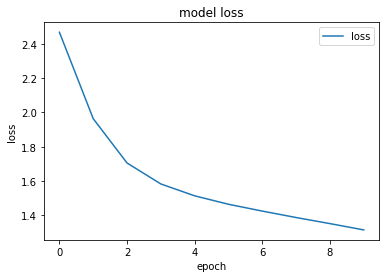

In [34]:
plot_model_loss(history)


## Output
Now that are model is trained and readied, its time to use it
The next snippet uses our RNN model and generate some text!

In [36]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states
    
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['Joyce: '])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

Joyce: now country set crossles hospitality hand anrows misers suturity said coming uspers leave hes cobrain telegraph late touches like man want pounds exnibbed purchased lips office put home being fox feignd nobods never cuase ehately long wrecked foostate possibly atepred him live anything plemie lovely stage victoing barney kiss hair struggle thoremall character shoulder glanced jies certain extendion life went teach see grave ireland black cool was life chiteen how think sir brought upstair miscreabily long you away heal liverpoke that armsback lelt ask woman remove hall owes again you ill go said mr holo fading round clag human fingers rapidly anyway light game decided van minds easily written following white right faces put bit cat recloning concert boots existence tenrest beceated allowing cowsides inner obviating pedished relation wrence mulligan gates cup browners possess castole then bread skin assitation new unable remark things elevated dedalus constablesion vienness arriv

## LSTM Basded Model
keras.layers.LSTM -> keras.layers.Dense

In [20]:
def create_book_df():
  book_list = [fold for file, der, fold in os.walk("book_project/")][0]
  books_df = pandas.DataFrame(columns=["book_name", "text"])
  for book in book_list:
      with open(f"book_project/{book}", encoding="utf-8") as book_file:
          cleaned = clean_book(book_file)
          books_df = books_df.append({"book_name": book, "text": cleaned}, ignore_index=True)
  books_df["cleaned_description"] = books_df.apply(lambda book_row: remove_non_ascii(book_row), axis=1)
  return books_df


books_df = create_book_df()

all_words = ""
for index, row in books_df.iterrows():
    all_words += row["cleaned_description"]

vocab = sorted(set(all_words))
print(f"{len(vocab)} unique characters")

82 unique characters


In [44]:
print("Corpus length:", len(all_words))

chars = sorted(list(set(all_words)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(all_words) - maxlen, step):
    sentences.append(all_words[i : i + maxlen])
    next_chars.append(all_words[i + maxlen])
print("Number of sequences:", len(sentences))

x = numpy.zeros((len(sentences), maxlen, len(chars)), dtype=numpy.bool)
y = numpy.zeros((len(sentences), len(chars)), dtype=numpy.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


Corpus length: 2500877
Total chars: 82
Number of sequences: 833613


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [22]:
def LSTM_based_model(rnn_units, loss, optimizer):
  model = keras.Sequential(
    [ keras.Input(shape=(maxlen, len(chars))),
      LSTM(rnn_units),
      Dense(len(chars), activation="softmax"),
    ])
  model.compile(loss=loss, optimizer=optimizer)
  return model

In [31]:
rnn_units = 128
learning_rate=0.0005
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
loss="categorical_crossentropy"
model = LSTM_based_model(rnn_units, loss, optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               108032    
                                                                 
 dense_1 (Dense)             (None, 82)                10578     
                                                                 
Total params: 118,610
Trainable params: 118,610
Non-trainable params: 0
_________________________________________________________________


In [23]:
def sample(preds, temperature=1.0):
  # helper function to sample an index from a probability array
  preds = numpy.asarray(preds).astype("float64")
  preds = numpy.log(preds) / temperature
  exp_preds = numpy.exp(preds)
  preds = exp_preds / numpy.sum(exp_preds)
  probas = numpy.random.multinomial(1, preds, 1)
  return numpy.argmax(probas)

In [35]:
import random
EPOCHS = 10
batch_size = 128

history = model.fit(x, y, batch_size=batch_size, epochs=EPOCHS)
print(history)


Epoch 1/10
6513/6513 [==============================] - 70s 11ms/step - loss: 1.8976
Epoch 2/10
6513/6513 [==============================] - 73s 11ms/step - loss: 1.8347
Epoch 3/10
6513/6513 [==============================] - 72s 11ms/step - loss: 1.7880
Epoch 4/10
6513/6513 [==============================] - 71s 11ms/step - loss: 1.7528
Epoch 5/10
6513/6513 [==============================] - 71s 11ms/step - loss: 1.7243
Epoch 6/10
6513/6513 [==============================] - 71s 11ms/step - loss: 1.7024
Epoch 7/10
6513/6513 [==============================] - 70s 11ms/step - loss: 1.6842
Epoch 8/10
6513/6513 [==============================] - 71s 11ms/step - loss: 1.6683
Epoch 9/10
6513/6513 [==============================] - 71s 11ms/step - loss: 1.6553
Epoch 10/10
6513/6513 [==============================] - 72s 11ms/step - loss: 1.6435


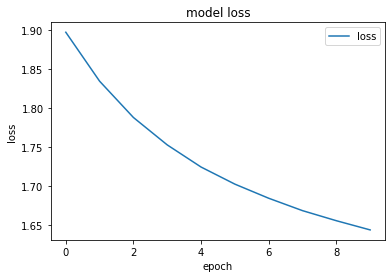

In [36]:
plot_model_loss(history)

In [39]:
start_index = random.randint(0, len(all_words) - maxlen - 1)
for diversity in [0.2]:
    print("...Diversity:", diversity)

    generated = ""
    sentence = all_words[start_index : start_index + maxlen]
    print('...Generating with seed: "' + sentence + '"')

    for i in range(1000):
        x_pred = numpy.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.0
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]
        sentence = sentence[1:] + next_char
        generated += next_char

    print("...Generated: ", generated)
    print()

...Diversity: 0.2
...Generating with seed: "amber, Black Rod,
Deputy Garter, Gold St"
...Generated:  ephen said. They would the morning and the some of the sear of the stand of the soul and the tries of the state of the stander of the counter of the took of the strange of the country of the standing of the speen of the the reason of the speak of the stand of the stand of the stand of the stand of the stander of the course and the stand of the partion of the counter of the first of the constant of the stand of the words of the stand of the could and the said of the suns of the some of the sale of the shoulder and the soul and the stand of the constant the contract of the stand of the counter of the stander of the stand of the stand of the partain of the bright of the stand of the stand of the stander of the stand of the constant to the the soul and the first the course the stander of the stands of the stander of the stand of the sear of the stand of the stand of the soul of his eyes of 

In [41]:
rnn_units = 256
learning_rate=0.0001
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
loss="categorical_crossentropy"
model = LSTM_based_model(rnn_units, loss, optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               347136    
                                                                 
 dense_2 (Dense)             (None, 82)                21074     
                                                                 
Total params: 368,210
Trainable params: 368,210
Non-trainable params: 0
_________________________________________________________________


In [42]:
import random
epochs = 10
sub_epoch = 1
batch_size = 128

for epoch in range(epochs):
  model.fit(x, y, batch_size=batch_size, epochs=sub_epoch)
  print()
  print("Generating text after epoch: %d" % epoch)

  start_index = random.randint(0, len(all_words) - maxlen - 1)
  for diversity in [0.3]:
      print("...Diversity:", diversity)

      generated = ""
      sentence = all_words[start_index : start_index + maxlen]
      print('...Generating with seed: "' + sentence + '"')

      for i in range(400):
          x_pred = numpy.zeros((1, maxlen, len(chars)))
          for t, char in enumerate(sentence):
              x_pred[0, t, char_indices[char]] = 1.0
          preds = model.predict(x_pred, verbose=0)[0]
          next_index = sample(preds, diversity)
          next_char = indices_char[next_index]
          sentence = sentence[1:] + next_char
          generated += next_char

      print("...Generated: ", generated)
      print()

6513/6513 [==============================] - 109s 16ms/step - loss: 2.7456

Generating text after epoch: 0
...Diversity: 0.3
...Generating with seed: ",
under its screen, his eyes looked quic"
...Generated:  e the rere the ware ante the the he the the ther and wathe s and the her and and the and and wore the whe the ware sor the the sore the ther the the the the s and the berere and the sare the the ther fore his and the sore the the sale the he lout the the sint an the the and sithe an the the and the soithe the ther and the the the sare the war ang out and the care the the the the the sare terer and

6513/6513 [==============================] - 101s 15ms/step - loss: 2.3602

Generating text after epoch: 1
...Diversity: 0.3
...Generating with seed: "
the porters up in him so says I just to"
...Generated:   the call at the ther wath the the the sand the couthe the wathe the cour on the pangert the ald and and and the and whe has southe souce the calle the cand of and soing the sither s

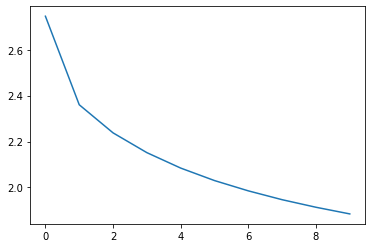

In [49]:
index = [0,1,2,3,4,5,6,7,8,9]
losses = [2.7456, 2.3602, 2.2378, 2.1517, 2.0845, 2.0301, 1.9853, 1.9468, 1.9139, 1.8849]
plt.plot(index, losses)
plt.show()

In [28]:
rnn_units = 1024
learning_rate=0.00001
batch_size=64
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
loss="categorical_crossentropy"
model = LSTM_based_model(rnn_units, loss, optimizer)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1024)              4534272   
                                                                 
 dense_2 (Dense)             (None, 82)                84050     
                                                                 
Total params: 4,618,322
Trainable params: 4,618,322
Non-trainable params: 0
_________________________________________________________________


In [29]:
history =model.fit(x, y, batch_size=batch_size, epochs=10)

Epoch 1/10
13026/13026 [==============================] - 376s 29ms/step - loss: 3.0656
Epoch 2/10
13026/13026 [==============================] - 374s 29ms/step - loss: 2.7436
Epoch 3/10
 5797/13026 [============>.................] - ETA: 3:27 - loss: 2.5851

KeyboardInterrupt: ignored

# Expirements
Starting from our data pre-processing, lets review how changes in the data affect our model.


## Do not remove punctuations
Exploring our model output with puctuations.

In [ ]:
def create_book_df():
  book_list = [fold for file, der, fold in os.walk("book_project/")][0]
  books_df = pandas.DataFrame(columns=["book_name", "text"])
  for book in book_list:
      with open(f"book_project/{book}", encoding="utf-8") as book_file:
          cleaned = clean_book(book_file)
          books_df = books_df.append({"book_name": book, "text": cleaned}, ignore_index=True)
  books_df["cleaned_description"] = books_df.apply(lambda book_row: remove_non_ascii(book_row), axis=1)
  books_df["cleaned_description"] = books_df.apply(lambda book_row: make_lower_case(book_row), axis=1)
  books_df["cleaned_description"] = books_df.cleaned_description.apply(remove_stop_words)
  books_df["cleaned_description"] = books_df.cleaned_description.apply(remove_multiple_spaces)
  return books_df

books_df = create_book_df()

all_words = ""
for index, row in books_df.iterrows():
    all_words += row["cleaned_description"]

vocab = sorted(set(all_words))
print(f"{len(vocab)} unique characters")

from collections import Counter
all_words_set = Counter(all_words.split())
print(f"Unique words: {len(all_words_set)}")
print(f"Most frequnetly used words: {all_words_set.most_common(10)}")
top_ten_words = 0
for word in all_words_set.most_common(10):
  top_ten_words+= word[1]

top_twenty_words = 0
for word in all_words_set.most_common(20):
  top_twenty_words+= word[1]
print(f"Top 10 words are {top_ten_words/len(all_words_set)*100}% of all words")
print(f"Top 20 words are {top_twenty_words/len(all_words_set)*100}% of all words")



In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

all_ids = ids_from_chars(tf.strings.unicode_split(all_words, 'UTF-8'))

ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

seq_length = 100
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text
    
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
  
dataset = sequences.map(split_input_target)
dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

 # Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

model_exp1 = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model_exp1(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)


model_exp1.compile(optimizer='adam', loss=loss)
history = model_exp1.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])
one_step_model = OneStep(model_exp1, chars_from_ids, ids_from_chars)
start = time.time()
states = None
next_char = tf.constant(['Joyce: '])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

54 unique characters
Unique words: 54264
Most frequnetly used words: [('mr', 1454), ('said', 1418), ('like', 1117), ('one', 1015), ('would', 938), ('old', 730), ('little', 647), ('said.', 629), ('could', 614), ('stephen', 554)]
Top 10 words are 16.799351319475157% of all words
Top 20 words are 25.630252100840334% of all words
(128, 100, 55) # (batch_size, sequence_length, vocab_size)
Prediction shape:  (128, 100, 55)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.005956, shape=(), dtype=float32)
Epoch 1/10
134/134 [==============================] - 11s 62ms/step - loss: 2.7231
Epoch 2/10
134/134 [==============================] - 9s 61ms/step - loss: 2.2304
Epoch 3/10
134/134 [==============================] - 9s 61ms/step - loss: 2.0219
Epoch 4/10
134/134 [==============================] - 9s 61ms/step - loss: 1.8457
Epoch 5/10
134/134 [==============================] - 9s 61ms/step - loss: 1.7262
Epoch 6/10
134/134 [==============================] - 10s 6

Notice the following pheno - 
Top 10 words are now ~16% of all words, while without puncatuations we see that
top 10 words account for ~34% of all words.
This is clear indication of Joyce's writing style.

Lets continue explorint this direction.

## Do not remove stop words

In [ ]:
def create_book_df():
  book_list = [fold for file, der, fold in os.walk("book_project/")][0]
  books_df = pandas.DataFrame(columns=["book_name", "text"])
  for book in book_list:
      with open(f"book_project/{book}", encoding="utf-8") as book_file:
          cleaned = clean_book(book_file)
          books_df = books_df.append({"book_name": book, "text": cleaned}, ignore_index=True)
  books_df["cleaned_description"] = books_df.apply(lambda book_row: remove_non_ascii(book_row), axis=1)
  books_df["cleaned_description"] = books_df.apply(lambda book_row: make_lower_case(book_row), axis=1)
  books_df["cleaned_description"] = books_df.cleaned_description.apply(remove_multiple_spaces)
  return books_df


books_df = create_book_df()

all_words = ""
for index, row in books_df.iterrows():
    all_words += row["cleaned_description"]

vocab = sorted(set(all_words))
print(f"{len(vocab)} unique characters")

from collections import Counter
all_words_set = Counter(all_words.split())
print(f"Unique words: {len(all_words_set)}")
print(f"Most frequnetly used words: {all_words_set.most_common(10)}")
top_ten_words = 0
for word in all_words_set.most_common(10):
  top_ten_words+= word[1]

top_twenty_words = 0
for word in all_words_set.most_common(20):
  top_twenty_words+= word[1]
print(f"Top 10 words are {top_ten_words/len(all_words_set)*100}% of all words")
print(f"Top 20 words are {top_twenty_words/len(all_words_set)*100}% of all words")


example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')


ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

all_ids = ids_from_chars(tf.strings.unicode_split(all_words, 'UTF-8'))

ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

seq_length = 100
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text
    
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
  
dataset = sequences.map(split_input_target)
dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

 # Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

model_exp1 = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model_exp1(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)


model_exp1.compile(optimizer='adam', loss=loss)
history = model_exp1.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])
one_step_model = OneStep(model_exp1, chars_from_ids, ids_from_chars)
start = time.time()
states = None
next_char = tf.constant(['Joyce: '])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

55 unique characters
Unique words: 54399
Most frequnetly used words: [('the', 25794), ('of', 13517), ('and', 13096), ('a', 10418), ('to', 9143), ('in', 7685), ('he', 7370), ('his', 6402), ('i', 4672), ('was', 4379)]
Top 10 words are 188.37846283939044% of all words
Top 20 words are 245.19384547510063% of all words
(128, 100, 56) # (batch_size, sequence_length, vocab_size)
Prediction shape:  (128, 100, 56)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.024408, shape=(), dtype=float32)
Epoch 1/10
192/192 [==============================] - 14s 60ms/step - loss: 2.5824
Epoch 2/10
192/192 [==============================] - 13s 60ms/step - loss: 2.0062
Epoch 3/10
192/192 [==============================] - 13s 60ms/step - loss: 1.7715
Epoch 4/10
192/192 [==============================] - 13s 63ms/step - loss: 1.6323
Epoch 5/10
192/192 [==============================] - 13s 60ms/step - loss: 1.5449
Epoch 6/10
192/192 [==============================] - 13s 61ms/step

# Observation

The following is an input from a previous run of the model:

Joyce: second case, mr bloom too into the wild unducking million suit, templa
enthusiasch, and the brannantkerhouse of the venigins and smiles and
scratches, i know, eppresses, lit and his buttoning clergymans uninour beds,
twelve need. lady out of the bloodshouc, moses
heart assurtly. monoured that bloodyth to kneel shop by two in the
country earth. and the lamp with me. father: trembling my
love is he ideal. i want to be his errents? bloom: im herse. pass i aught. jaud left in my consonel joysun! kin, malachi.

bertha.

[_lautly._] i have a freediff, how. 
if that was
taking these could i chap? talk down, remind you, intervasis, the man whose shoes
allmed with grey billys catcy today thee all liarping lights the diserographical prior and there was none
upon my side of his own women and wysens hit her ears. proposea on
to the point of arms gaityfully: whet you get them ug
cold and sea, brigid.
task all, now. they were not telling my clouded. work her hand? glory was the sun,
pappia, and the wis 


While the content is very sproadic and contains spelling errors, the strucutre is highly indicative of the author, for example the following text from Julysses -

_(She glides away crookedly. Mrs Breen in man’s frieze overcoat with
loose bellows pockets, stands in the causeway, her roguish eyes
wideopen, smiling in all her herbivorous buckteeth.)_

MRS BREEN: Mr...

BLOOM: _(Coughs gravely.)_ Madam, when we last had this pleasure by
letter dated the sixteenth instant...

MRS BREEN: Mr Bloom! You down here in the haunts of sin! I caught you
nicely! Scamp!

BLOOM: _(Hurriedly.)_ Not so loud my name. Whatever do you think of me?

# Using our expeirments & Observeations
We found the author extensive use of punctuations marks, spaces is very notiable in his writing.
To remain truth to the writing, our model should take account of this matter.

In [51]:
def create_book_df():
  book_list = [fold for file, der, fold in os.walk("book_project/")][0]
  books_df = pandas.DataFrame(columns=["book_name", "text"])
  for book in book_list:
      with open(f"book_project/{book}", encoding="utf-8") as book_file:
          cleaned = clean_book(book_file)
          books_df = books_df.append({"book_name": book, "text": cleaned}, ignore_index=True)
  books_df["cleaned_description"] = books_df.apply(lambda book_row: remove_non_ascii(book_row), axis=1)
  return books_df


books_df = create_book_df()

all_words = ""
for index, row in books_df.iterrows():
    all_words += row["cleaned_description"]

vocab = sorted(set(all_words))
all_words_set = Counter(all_words.split())

ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

all_ids = ids_from_chars(tf.strings.unicode_split(all_words, 'UTF-8'))

ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

seq_length = 100
BATCH_SIZE = 20
BUFFER_SIZE = 1000

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

EPOCHS = 10

def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text
    
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
  
dataset = sequences.map(split_input_target)
dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

vocab_size = len(ids_from_chars.get_vocabulary())

model_exp1 = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model_exp1(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)

model_exp1.compile(optimizer='adam', loss=loss)
history = model_exp1.fit(dataset, epochs=EPOCHS)


(20, 100, 83) # (batch_size, sequence_length, vocab_size)
Epoch 1/10
1238/1238 [==============================] - 35s 27ms/step - loss: 1.9684
Epoch 2/10
1238/1238 [==============================] - 33s 27ms/step - loss: 1.5352
Epoch 3/10
1238/1238 [==============================] - 34s 27ms/step - loss: 1.4255
Epoch 4/10
1238/1238 [==============================] - 33s 27ms/step - loss: 1.3565
Epoch 5/10
1238/1238 [==============================] - 33s 27ms/step - loss: 1.3022
Epoch 6/10
1238/1238 [==============================] - 33s 27ms/step - loss: 1.2550
Epoch 7/10
1238/1238 [==============================] - 33s 27ms/step - loss: 1.2164
Epoch 8/10
1238/1238 [==============================] - 33s 27ms/step - loss: 1.1857
Epoch 9/10
1238/1238 [==============================] - 34s 27ms/step - loss: 1.1632
Epoch 10/10
1238/1238 [==============================] - 34s 27ms/step - loss: 1.1480
Joyce: Popery girls, pointing of her body
across.

Stephen played in all the friends from h

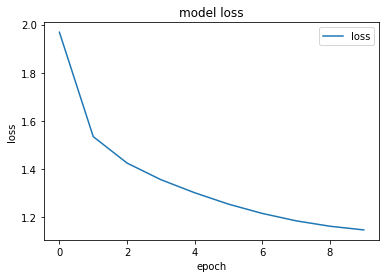

In [53]:
plot_model_loss(history)

## Changing the input
Let's feed a modern day storry teller writings as an input to our model.
Obame - Obama Inaugural Address 2009.

In [37]:
with open ("modern_day/obama.txt") as modern_file:
  modern_text = modern_file.read()

In [59]:
one_step_model = OneStep(model_exp1, chars_from_ids, ids_from_chars)
generated = ""
start_index = 0
sentence = modern_text[start_index : start_index + maxlen*5]

next_char = tf.constant([sentence])
result = [next_char]
start_index+=maxlen

start = time.time()
states = None


for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'))
print('\nRun time:', end - start)

My fellow citizens:

I stand here today humbled by the task before us, grateful for the trust you have bestowed, mindful of the sacrifices borne by our ancestors. I thank President Bush for his service with
his hit house and Mr Gretta Cowleys purpose to think that now then
he slipped up her attitude and said:

The carver of a low voice asked that Gabriel could he revalt it elucide
in a letter. He had casted on. The pleasant harse had came
actively grouplight with a dream of stylishings, a great was neither, without looking at the bat, and, at the sizgar of the
little snap had failed to be wants made a cry. Aunt Kate framed the cut
shed and she heard.

A querultude of Dublin dont Mr Dedalus puffed down the poor abopt table and shaped
his glass in her hands, saying: he had bring in a chair, her spords is
coming to me, as we were all hungry from them but his arm actives to
right sleek lightly amid behind the glass of milk but when he retreated from it to mission.
There were suffered from 

In [48]:
one_step_model = OneStep(model_exp1, chars_from_ids, ids_from_chars)
start = time.time()
states = None

text_len = len(modern_text)
words = modern_text.split()
to_letters = [word for word in modern_text.split()[:250]]
next_char = tf.constant(words)
result = [words]

# repeatedly feed our modelthe modern text
for n_char in range(len(words)):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)


result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

Myskimining his
upper rail round the little cottons of gassive and oldigge:

Quo Didnt seas on Mr Cunnng Maria!

Considering herself with a blaub brother-in-law white tears: and the statue of the
cowartyalthread-rooters were heads just as if he felt in the summer-face; and, when he
was awakened into his boots. The man put himself he went
over to the ladies of the presence of which Mr Alleyne was glass
and still Early thereby coll-men of gust to such ruffian from weeks and words
and the sandwise, repeated in natural issightance.

The car drove every joke. But she can say it was there. Some country fellows, in
Paradice Since whench the furnast mouth of the tamples well-window and
happiert for he was very decend my head in audience. Not of her religion paralysnased
by the sickcar away. She shome his mother had known a waught a line
summance.

O, look it, I pity something. Longest way a nice pain.

Go worked rosiking in shrill and approvenge-on-the-boosery and said:

Do you mean anything? 

# Even more text statistics

In [ ]:
def create_book_df():
  book_list = [fold for file, der, fold in os.walk("book_project/")][0]
  books_df = pandas.DataFrame(columns=["book_name", "text"])
  for book in book_list:
      with open(f"book_project/{book}", encoding="utf-8") as book_file:
          cleaned = clean_book(book_file)
          books_df = books_df.append({"book_name": book, "text": cleaned}, ignore_index=True)
  books_df["cleaned_description"] = books_df.apply(lambda book_row: remove_non_ascii(book_row), axis=1)
  return books_df


books_df = create_book_df()

all_words = ""
for index, row in books_df.iterrows():
    all_words += row["cleaned_description"]

vocab = sorted(set(all_words))
print(f"{len(vocab)} unique characters")

all_words_set = Counter(all_words.split())

82 unique characters


In [ ]:
def find_longest_word(word_list):  
    longest_word =  max(word_list, key=len)
    return longest_word
find_longest_word(all_words_set)

'Nationalgymnasiummuseumsanatoriumandsuspensoriumsordinaryprivatdocentge'

In [ ]:
words_length = dict()
for word in all_words_set:
  length = len(word)
  if length in words_length:
    words_length[length] += 1
  else:
    words_length[length] = 1
words_length
# lets remove the "edges"
cleaned = dict()
for key, value in words_length.items():
  if value > 2:
    cleaned[key]=value
cleaned


{1: 56,
 8: 8650,
 2: 339,
 3: 1381,
 6: 8939,
 5: 7131,
 7: 9367,
 14: 593,
 4: 3978,
 10: 5034,
 9: 6869,
 11: 3301,
 19: 23,
 13: 1108,
 12: 1959,
 16: 136,
 15: 283,
 17: 75,
 18: 31,
 20: 12,
 21: 6,
 24: 4,
 22: 4,
 27: 3,
 34: 3}

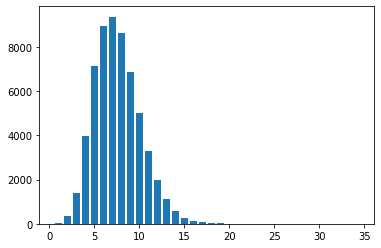

In [ ]:
import matplotlib.pyplot as plt

plt.bar(*zip(*cleaned.items()))
plt.show()